In [1]:
%cd ..
%load_ext autoreload

/ems/elsc-labs/mezer-a/niv.amos/repos/qMRI Analyzer - Code


In [2]:
import enum
import seaborn as sns
from data_handling.Data_Processor import DataProcessor
import constants
from statistics_methods.Statistics import StatisticsWrapper
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, precision_score, recall_score, f1_score
import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import shap
from statistics_methods.plots import PlotsManager
import numpy as np
import wandb
from sklearn.model_selection import RandomizedSearchCV

/ems/elsc-labs/mezer-a/niv.amos/.conda/envs/qmri/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
chosen_rois_dict = constants.ROI_CORTEX
params_to_work_with = constants.ALL_PARAMS

In [26]:
def load_data(data_path, outliers=[]):
    subjects_raw_data = DataProcessor(data_path, chosen_rois_dict, chosen_rois_dict).get_data_proccessed()
    analyzed_data = StatisticsWrapper.calc_median_per_subject_per_parameter_per_ROI(subjects_raw_data, params_to_work_with)
    chosen_data = StatisticsWrapper.chose_relevant_data(analyzed_data, chosen_rois_dict, params_to_work_with, params_to_work_with)

    chosen_data = chosen_data[~chosen_data.subjects.isin(outliers)]
    # chosen_data = chosen_data.drop(columns=constants.SLOPES)
    chosen_data['ROI'] = chosen_data['ROI'].astype(str)
    chosen_data['subjects'] = chosen_data['subjects'].astype(str)

    group_a_name, group_b_name, col_divider, threshold = constants.YOUNG, constants.OLD, 'Age', constants.AGE_THRESHOLD
    young_subjects, old_subjects = StatisticsWrapper.seperate_data_to_two_groups(chosen_data, col_divider, threshold)

    return chosen_data, young_subjects, old_subjects

def create_evaluation_report(data, y_test, y_pred):
    # Add predictions to the test dataset
    test_results = data.copy()
    test_results["predicted_label"] = y_pred
    test_results["label"] = y_test

    # Group by name and calculate evaluation metrics for each group
    name_groups = test_results.groupby("ROI_name")
    evaluation_results = []

    for name, group in name_groups:
        true_labels = group["label"]
        predicted_labels = group["predicted_label"]
        
        evaluation_results.append({
            "ROI": name,
            "Accuracy": accuracy_score(true_labels, predicted_labels),
            "Precision": precision_score(true_labels, predicted_labels),
            "Recall": recall_score(true_labels, predicted_labels),
            "F1-score": f1_score(true_labels, predicted_labels)
        })

    # Convert evaluation results to DataFrame for easier visualization
    evaluation_df = pd.DataFrame(evaluation_results)
    return evaluation_df

In [5]:
outliers = ['H047_DC', 'H036_EV', 'H054_AE', 'H046_NB']
# outliers = []
chosen_data_raw, young_subjects_raw, old_subjects_raw = load_data(constants.PATH_TO_CORTEX_all_params_raw, outliers=outliers)
chosen_data_z_score, young_subjects_z_score, old_subjects_z_score = load_data(constants.PATH_TO_CORTEX_all_params_z_score, outliers=outliers)

# Cortex binary classification

In [29]:
data = chosen_data_raw.copy()
seed = 42
young_mask = young_subjects_raw.index
old_mask = old_subjects_raw.index

# Assign labels directly to data_reduced_tsne DataFrame
data.loc[young_mask, 'label'] = 0
data.loc[old_mask, 'label'] = 1

data = data.sample(frac=1)

x, y = data.drop(columns=['label']), data['label']
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=data['ROI_name'], random_state=seed)

In [61]:
# Convert data to DMatrix
dtrain = xgb.DMatrix(x_train[params_to_work_with], label=y_train)
params = {
    "objective": "binary:logistic",  # Adjust for your task
    "eval_metric": "error",         # 'error' for binary, 'merror' for multiclass
    "eta": 0.1,
    "max_depth": 4
}
params['lambda'] = 10
params['alpha'] = 3
params['min_child_weight'] = 5

# Cross-validation
cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=100,
    nfold=10,
    stratified=True,
    seed=42,
    early_stopping_rounds=10,
    verbose_eval=True
)

[0]	train-error:0.16955+0.00771	test-error:0.20433+0.02613
[1]	train-error:0.16721+0.00681	test-error:0.20209+0.02471
[2]	train-error:0.16345+0.00913	test-error:0.19983+0.03145
[3]	train-error:0.16178+0.01188	test-error:0.20133+0.03205
[4]	train-error:0.15619+0.00752	test-error:0.19529+0.03902
[5]	train-error:0.15410+0.00563	test-error:0.19003+0.03666
[6]	train-error:0.14926+0.00705	test-error:0.18853+0.03876
[7]	train-error:0.14300+0.00716	test-error:0.18027+0.03875
[8]	train-error:0.13824+0.00607	test-error:0.18478+0.03909
[9]	train-error:0.13524+0.00626	test-error:0.17876+0.03886
[10]	train-error:0.13140+0.00428	test-error:0.17201+0.03493
[11]	train-error:0.12714+0.00440	test-error:0.16827+0.03367
[12]	train-error:0.12630+0.00387	test-error:0.16301+0.03546
[13]	train-error:0.12363+0.00321	test-error:0.16225+0.03464
[14]	train-error:0.12138+0.00445	test-error:0.16226+0.03369
[15]	train-error:0.11887+0.00361	test-error:0.16301+0.03229
[16]	train-error:0.11804+0.00374	test-error:0.1615

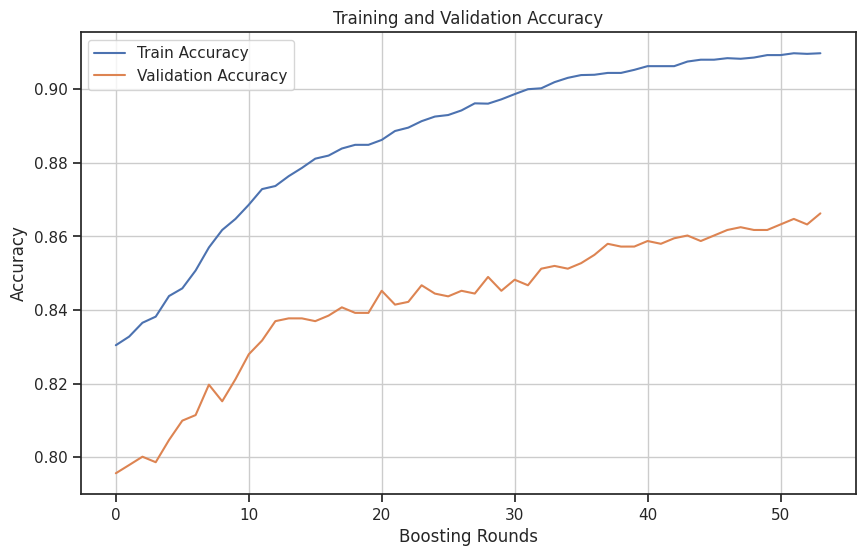

In [62]:
# Extract train and validation accuracy
train_accuracy = 1 - cv_results['train-error-mean']
validation_accuracy = 1 - cv_results['test-error-mean']

# Plot the accuracy
plt.figure(figsize=(10, 6))
plt.plot(train_accuracy, label='Train Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.xlabel('Boosting Rounds')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid()
plt.show()

In [7]:
def classify_data(x_train, y_train, x_test, y_test, title, params):    
    global classification_df
    
    # Create and train the model
    model = xgb.XGBClassifier(**params)
    model.fit(x_train, y_train)

    # Make predictions
    predictions = model.predict(x_test)
    accuracy = accuracy_score(y_test, predictions)

    class_report = classification_report(y_test, predictions, output_dict=True)
    overall_metrics = {
        "precision": class_report["weighted avg"]["precision"],
        "recall": class_report["weighted avg"]["recall"],
        "f1-score": class_report["weighted avg"]["f1-score"],
        "accuracy": accuracy
    }

    current_report = pd.DataFrame.from_dict(overall_metrics, orient="index", columns=[title])

    # Merge with the cumulative DataFrame
    if classification_df is None:
        classification_df = current_report
    else:
        classification_df = pd.concat([classification_df, current_report], axis=1)

    return model

def plot_classification_report(project_name, title, classification_df):
    # Initialize a W&B run
    wandb.init(project=project_name, name=title)

    # Log the updated DataFrame to W&B
    wandb.log({"classification_report": wandb.Table(data=classification_df, columns=params_to_work_with)})

    # End the W&B run
    wandb.finish()


In [12]:
from itertools import combinations

# Assuming classify_data is your function and params_to_work_with is a list of parameter names
# Example: params_to_work_with = ['param1', 'param2', 'param3', ..., 'param7']
classification_df = None

for num_params in range(1, len(params_to_work_with) + 1):
    # Generate all combinations of num_params
    for param_combination in combinations(params_to_work_with, num_params):
        # Select the corresponding columns from x_train and x_test
        selected_params = list(param_combination)
        x_train_subset = x_train[selected_params]
        x_test_subset = x_test[selected_params]
        
        # Run classify_data with the selected parameters
        classify_data(
            x_train_subset, 
            y_train, 
            x_test_subset, 
            y_test, 
            f"{num_params}",  # Informative name
            {"random_state": seed}
        )

In [66]:
grouped_df = classification_df.groupby(by=classification_df.columns, axis=1).mean()
grouped_df

,1,2,3,4,5,6,7
precision,0.593449,0.653015,0.712378,0.768014,0.823850,0.867176,0.879917
recall,0.594166,0.653368,0.712312,0.767825,0.823538,0.867010,0.879880
f1-score,0.589952,0.651833,0.711592,0.767415,0.823200,0.866850,0.879771
accuracy,0.594166,0.653368,0.712312,0.767825,0.823538,0.867010,0.879880


(array([0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 ]),
 [Text(0, 0.55, '0.55'),
  Text(0, 0.6000000000000001, '0.60'),
  Text(0, 0.65, '0.65'),
  Text(0, 0.7000000000000001, '0.70'),
  Text(0, 0.75, '0.75'),
  Text(0, 0.8, '0.80'),
  Text(0, 0.8500000000000001, '0.85'),
  Text(0, 0.9000000000000001, '0.90')])

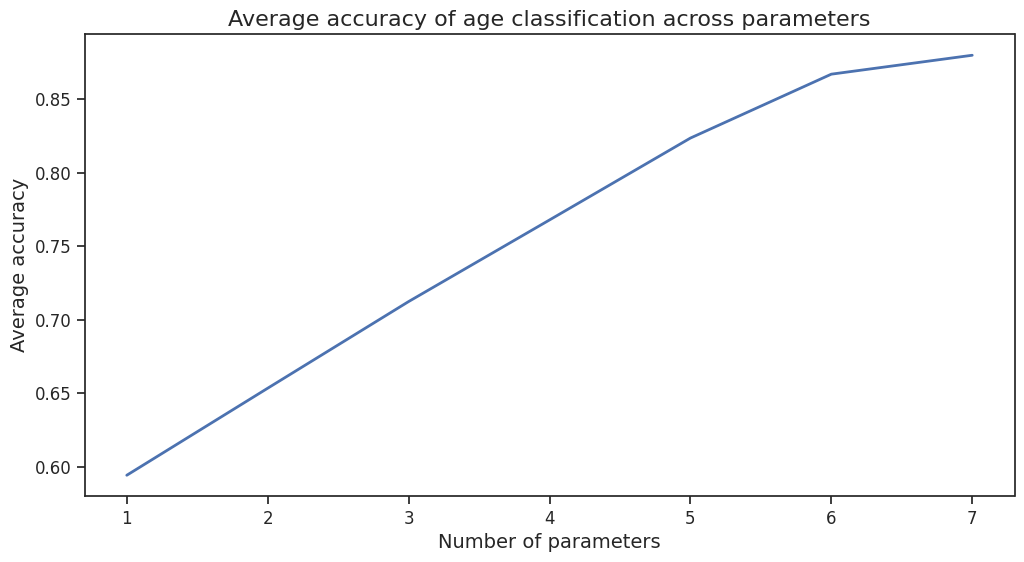

In [64]:
# plt.figure(figsize=(10, 6))
# plt.plot(grouped_df.columns, grouped_df.loc['accuracy'], label='accuracy', marker='o')

# # Add labels, legend, and title
# plt.xlabel("Parameters")
# plt.ylabel("Average accuracy")
# plt.title("Average accuracy Across Parameters")

# Create the plot
plt.figure(figsize=(12, 6))  # Larger figure size for better readability

# Plot the data with markers and line styles
plt.plot(grouped_df.columns, grouped_df.loc['accuracy'], linestyle='-', linewidth=2, markersize=2, label='Accuracy')

# Customize the axis labels and title
plt.xlabel("Number of parameters", fontsize=14)
plt.ylabel("Average accuracy", fontsize=14)
plt.title("Average accuracy of age classification across parameters", fontsize=16)

# Customize tick parameters
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Add a grid
# plt.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)

In [65]:
classification_df
# eval_df = create_evaluation_report(x_test, y_test, predictions)
# show_correlations_stats(chosen_data_z_score, young_subjects_z_score, old_subjects_z_score, 'pearson', eval_df)

,1,1,1,1,1,1,1,2,2,2,...,5,5,6,6,6,6,6,6,6,7
precision,0.521271,0.706890,0.605293,0.589716,0.619930,0.517743,0.593297,0.834990,0.654310,0.546547,...,0.805720,0.753521,0.882874,0.883007,0.889030,0.901144,0.850554,0.816755,0.846870,0.879917
recall,0.525526,0.705706,0.606607,0.591592,0.615616,0.519520,0.594595,0.834835,0.654655,0.549550,...,0.804805,0.753754,0.882883,0.882883,0.888889,0.900901,0.849850,0.816817,0.846847,0.879880
f1-score,0.520191,0.703152,0.605022,0.588048,0.601793,0.518165,0.593296,0.834541,0.654429,0.545642,...,0.804019,0.753392,0.882806,0.882745,0.888758,0.900949,0.849426,0.816601,0.846666,0.879771
accuracy,0.525526,0.705706,0.606607,0.591592,0.615616,0.519520,0.594595,0.834835,0.654655,0.549550,...,0.804805,0.753754,0.882883,0.882883,0.888889,0.900901,0.849850,0.816817,0.846847,0.879880


## Features analysis

<BarContainer object of 7 artists>

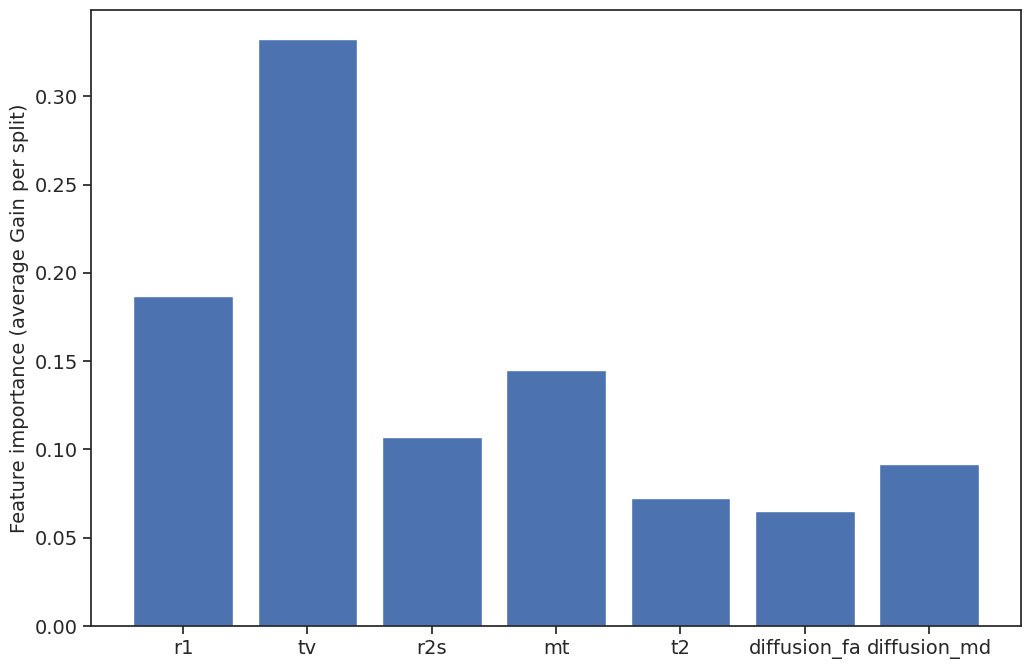

In [17]:
plt.figure(figsize=(12, 8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.ylabel('Feature importance (average Gain per split)', fontsize=14)
plt.bar(params_to_work_with, model.feature_importances_)